In [1]:
using OceananigansLagrangianFilter
using Oceananigans.Units
using CUDA


Precompiling packages...
   1679.7 ms  ✓ Oceananigans → OceananigansNCDatasetsExt
   3359.3 ms  ✓ Oceananigans → OceananigansCUDAExt
   4574.7 ms  ✓ Oceananigans → OceananigansMakieExt
   3623.9 ms  ✓ OceananigansLagrangianFilter
  4 dependencies successfully precompiled in 10 seconds. 353 already precompiled.


In [ ]:
filter_config = OfflineFilterConfig(original_data_filename="periodic_geostrophic_adjustment.jld2", # Where the original simulation output is
                                    var_names_to_filter = ("T", "b"), # Which variables to filter
                                    velocity_names = ("u","w"), # Velocities to use for Lagrangian filtering
                                    architecture = GPU(), # CPU() or GPU()
                                    Δt = 20minutes, # Time step of filtering simulation
                                    T_out=1hour, # How often to output filtered data
                                    N=2, # Order of Butterworth filter
                                    freq_c = 1e-4/2, # Cut-off frequency of Butterworth filter
                                    output_netcdf = false, # Whether to output filtered data to a netcdf file in addition to .jld2
                                    delete_intermediate_files = true, # Delete the individual output of the forward and backward passes
                                    compute_Eulerian_filter = true) # Whether to compute the Eulerian filter for comparison


[ Info: Filter interval will be from T_start=0.0 to T_end=345600.0, duration T=345600.0
[ Info: Setting filter parameters to use Butterworth squared, order 2, cutoff frequency 5.0e-5


OfflineFilterConfig("periodic_geostrophic_adjustment.jld2", ("T", "b"), ("u", "w"), 0.0, 345600.0, 345600.0, GPU{CUDABackend}(CUDABackend(false, true)), 3600.0, (a1 = 1.767766952966369e-5, b1 = 1.767766952966369e-5, c1 = 3.535533905932738e-5, d1 = 3.535533905932738e-5, N_coeffs = 1), 1200.0, InMemory{Int64}(1, 4), true, "forward_output.jld2", "backward_output.jld2", "filtered_output.jld2", 5, true, true, false, true, WENO{3, Float64, Float32}(order=5)
├── buffer_scheme: WENO{2, Float64, Float32}(order=3)
└── advection_velocity_scheme: Centered(order=4), 300×1×80 RectilinearGrid{Float64, Periodic, Flat, Bounded} on CUDAGPU with 3×0×3 halo
├── Periodic x ∈ [-5000.0, 5000.0) regularly spaced with Δx=33.3333
├── Flat y                         
└── Bounded  z ∈ [-100.0, 0.0]     regularly spaced with Δz=1.25, "offline")

In [4]:
run_offline_Lagrangian_filter(filter_config)

[ Info: Loaded data from periodic_geostrophic_adjustment.jld2
[ Info: Created original variables: (:T, :b)
[ Info: Created filtered variables: (:T_C1, :b_C1, :xi_u_C1, :xi_w_C1, :T_S1, :b_S1, :xi_u_S1, :xi_w_S1)
[ Info: Created forcing for filtered variables
[ Info: Created model
[ Info: Initialised filtered variables
[ Info: Defined outputs
[ Info: Defined simulation
[ Info: Initializing simulation...
[ Info: Simulation time: 0 seconds
[ Info:     ... simulation initialization complete (34.988 seconds)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (8.454 seconds).
[ Info: Simulation time: 1 hour
[ Info: Simulation time: 2 hours
[ Info: Simulation time: 3 hours
[ Info: Simulation time: 4 hours
[ Info: Simulation time: 5 hours
[ Info: Simulation time: 6 hours
[ Info: Simulation time: 7 hours
[ Info: Simulation time: 8 hours
[ Info: Simulation time: 9 hours
[ Info: Simulation time: 10 hours
[ Info: Simulation time: 11 hours
[ Info: Simulation time: 12 

In [5]:
# Animate
timeseries1 = FieldTimeSeries(filter_config.output_filename, "b")
timeseries2 = FieldTimeSeries(filter_config.output_filename, "b_Eulerian_filtered")
timeseries3 = FieldTimeSeries(filter_config.output_filename, "b_Lagrangian_filtered")
timeseries4 = FieldTimeSeries(filter_config.output_filename, "b_Lagrangian_filtered_at_mean")

times = timeseries1.times

set_theme!(Theme(fontsize = 20))
fig = Figure(size = (1300, 500))

axis_kwargs = (xlabel = "x",
               ylabel = "z",
               limits = ((-5000, 5000), (-100, 0)),
               aspect = AxisAspect(1))

ax1 = Axis(fig[2, 1]; title = "Raw", axis_kwargs...)
ax2 = Axis(fig[2, 2]; title = "Eulerian filtered", axis_kwargs...)
ax3 = Axis(fig[2, 3]; title = "Lagrangian filtered", axis_kwargs...)
ax4 = Axis(fig[2, 4]; title = "Lagrangian filtered at mean", axis_kwargs...)


n = Observable(1)
Observable(1)

var1 = @lift timeseries1[$n]
var2 = @lift timeseries2[$n]
var3 = @lift timeseries3[$n]
var4 = @lift timeseries4[$n]

heatmap!(ax1, var1; colormap = :balance, colorrange = (-1e-4, 1e-4))
heatmap!(ax2, var2; colormap = :balance, colorrange = (-1e-4, 1e-4))
heatmap!(ax3, var3; colormap = :balance, colorrange = (-1e-4, 1e-4))
heatmap!(ax4, var4; colormap = :balance, colorrange = (-1e-4, 1e-4))


title = @lift "Buoyancy, t = " * string(round(times[$n], digits=2))
Label(fig[1, 1:4], title, fontsize=24, tellwidth=false)

fig

frames = 1:length(times)

@info "Making an animation"

CairoMakie.record(fig, "LF_b_movie.mp4", frames, framerate=24) do i
    n[] = i
end

[ Info: Making an animation


"LF_b_movie.mp4"

In [6]:
# Animate
timeseries1 = FieldTimeSeries(filter_config.output_filename, "T")
timeseries2 = FieldTimeSeries(filter_config.output_filename, "T_Eulerian_filtered")
timeseries3 = FieldTimeSeries(filter_config.output_filename, "T_Lagrangian_filtered")
timeseries4 = FieldTimeSeries(filter_config.output_filename, "T_Lagrangian_filtered_at_mean")

times = timeseries1.times

set_theme!(Theme(fontsize = 20))
fig = Figure(size = (1300, 500))

axis_kwargs = (xlabel = "x",
               ylabel = "z",
               limits = ((-5000, 5000), (-100, 0)),
               aspect = AxisAspect(1))

ax1 = Axis(fig[2, 1]; title = "Raw", axis_kwargs...)
ax2 = Axis(fig[2, 2]; title = "Eulerian filtered", axis_kwargs...)
ax3 = Axis(fig[2, 3]; title = "Lagrangian filtered", axis_kwargs...)
ax4 = Axis(fig[2, 4]; title = "Lagrangian filtered at mean", axis_kwargs...)


n = Observable(1)
Observable(1)

var1 = @lift timeseries1[$n]
var2 = @lift timeseries2[$n]
var3 = @lift timeseries3[$n]
var4 = @lift timeseries4[$n]

heatmap!(ax1, var1; colormap = :Spectral, colorrange = (0, 1))
heatmap!(ax2, var2; colormap = :Spectral, colorrange = (0, 1))
heatmap!(ax3, var3; colormap = :Spectral, colorrange = (0, 1))
heatmap!(ax4, var4; colormap = :Spectral, colorrange = (0, 1))


title = @lift "Tracer concentration, t = " * string(round(times[$n], digits=2))
Label(fig[1, 1:4], title, fontsize=24, tellwidth=false)

fig

frames = 1:length(times)

@info "Making an animation"

CairoMakie.record(fig, "LF_T_movie.mp4", frames, framerate=24) do i
    n[] = i
end

[ Info: Making an animation


"LF_T_movie.mp4"

In [ ]:
t = Array(0:0.1:20)
freq = Array(-5:0.1:5)
tref = 10
G = get_weight_function(t, tref, filter_config.filter_params);
Ghat = get_frequency_response(freq, filter_config.filter_params);

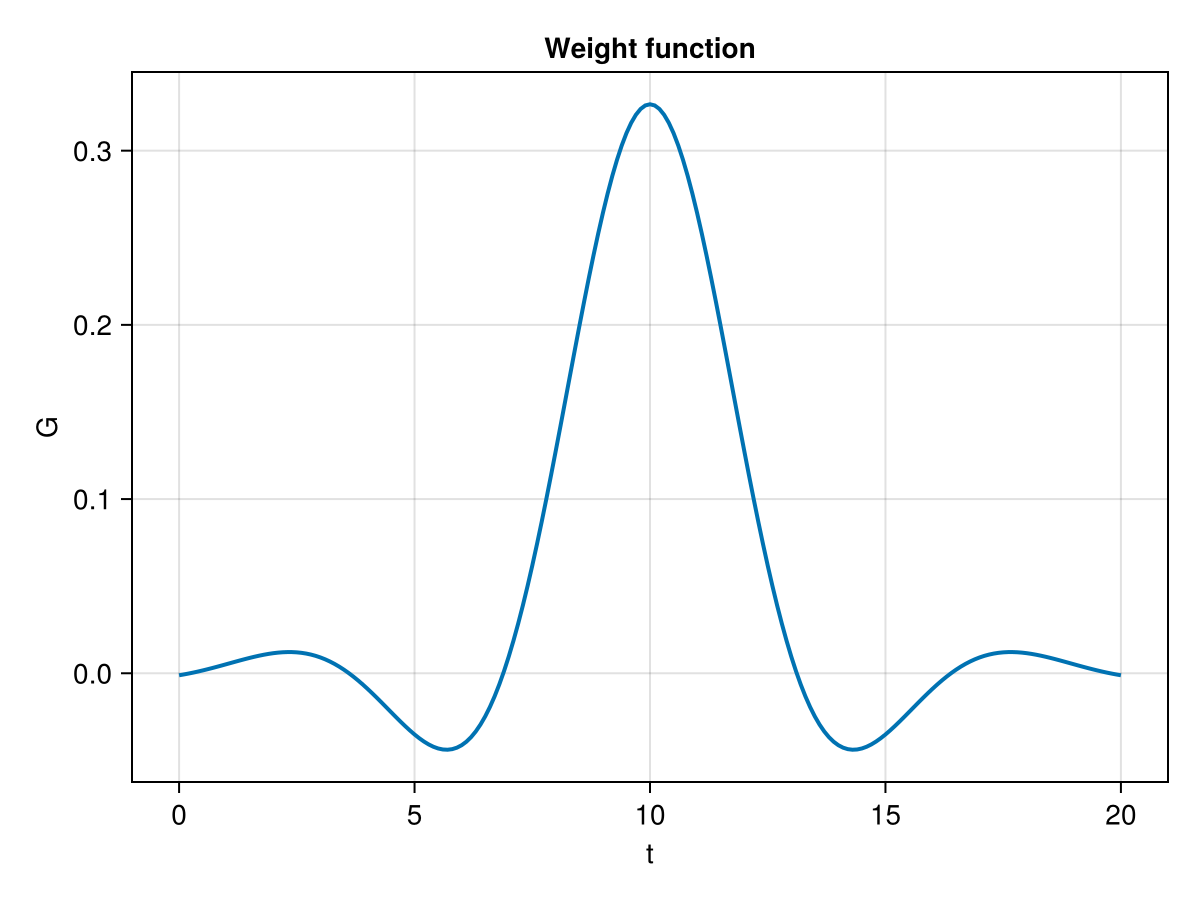

In [ ]:
fig = Figure()
ax = Axis(fig[1, 1], title = "Weight function", xlabel = "t", ylabel = "G")

# Plot the data on the axis
lines!(ax, t, G, label = "G(t)", linewidth = 2)
fig

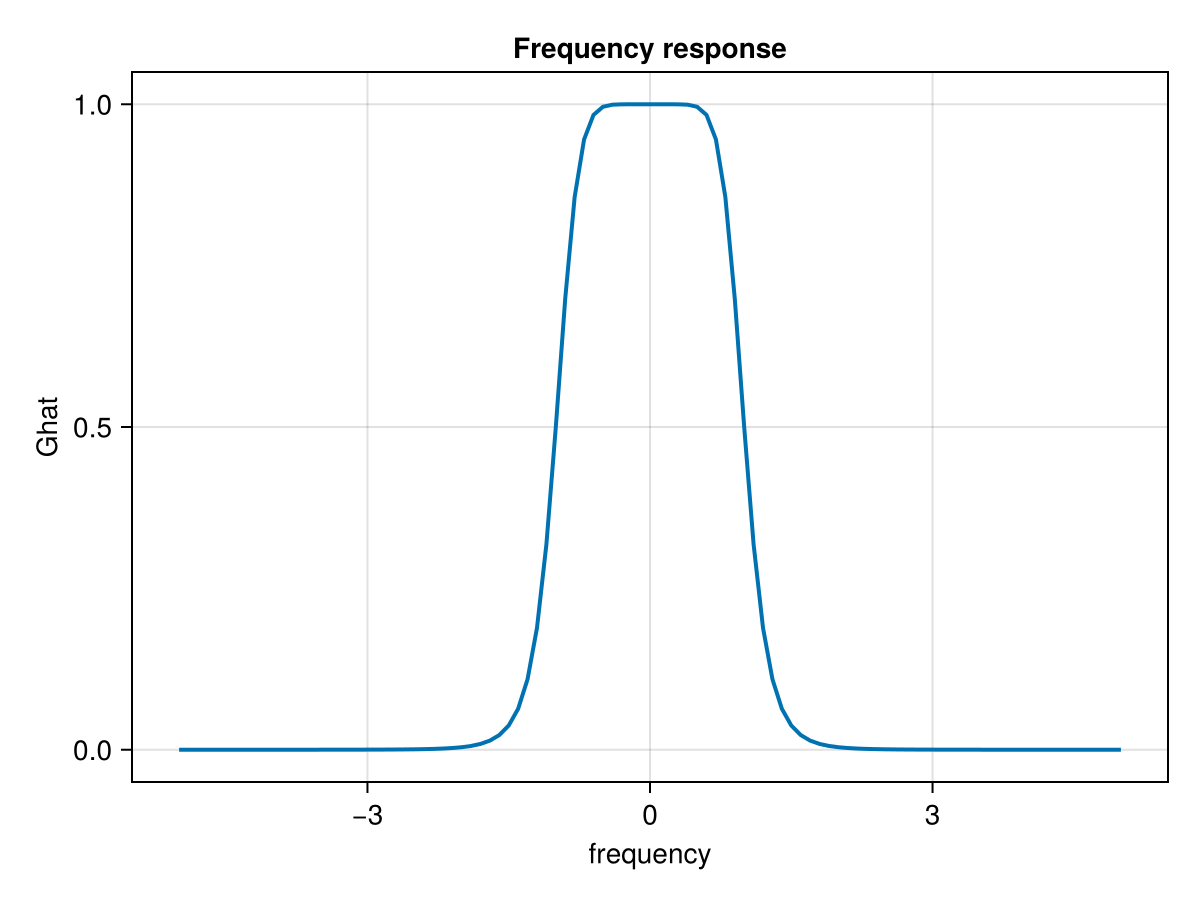

In [ ]:
fig = Figure()
ax = Axis(fig[1, 1], title = "Frequency response", xlabel = "frequency", ylabel = "Ghat")

# Plot the data on the axis
lines!(ax, freq, Ghat, linewidth = 2)
fig

In [25]:
using Oceananigans: AbstractArray

In [27]:
?AbstractArray

search: AbstractArray AbstractMatrix AbstractChar AbstractCamera AbstractPattern



```
AbstractArray{T,N}
```

Supertype for `N`-dimensional arrays (or array-like types) with elements of type `T`. [`Array`](@ref) and other types are subtypes of this. See the manual section on the [`AbstractArray` interface](@ref man-interface-array).

See also: [`AbstractVector`](@ref), [`AbstractMatrix`](@ref), [`eltype`](@ref), [`ndims`](@ref).
